In [40]:
import pandas as pd
import os
from pathlib import Path
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from mlforecast import MLForecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
#from src.data.feature_engineering import date_features, lags

## 1️⃣ Data preparation

In [39]:
import pandas as pd 



def prepare_df(df, unique_id='A'):

    df = df.copy()  
    df['ds'] = pd.to_datetime(df['Datetime']) 
    df['y'] = df['PJME_MW']                    
    df['unique_id'] = unique_id              
    df = df[['ds', 'y', 'unique_id']].sort_values('ds')  
    return df

In [41]:
# -------------------------------
# 1.1 Data Prepartion for Nixtla
# -------------------------------

PROJECT_ROOT = Path.cwd() 
raw_path = os.path.join(PROJECT_ROOT, 'data', 'raw', 'PJME_hourly.csv')  

raw_path =r'C:\Users\Guest\Desktop\ds-projects\Energy-Forecasting\data\raw\PJME_hourly.csv'


df= pd.read_csv(raw_path)  # raw CSV  
df = prepare_df(df)                      # clean, rename, add unique_id
print("Preprocessed data sample:")
print(df.head())

Preprocessed data sample:
                      ds        y unique_id
8734 2002-01-01 01:00:00  30393.0         A
8735 2002-01-01 02:00:00  29265.0         A
8736 2002-01-01 03:00:00  28357.0         A
8737 2002-01-01 04:00:00  27899.0         A
8738 2002-01-01 05:00:00  28057.0         A


In [42]:
# -------------------------------
# 1.2 Split into train and test
# -------------------------------
split_date = '2017-01-01'

train = df[df['ds'] < split_date ]
test  = df[df['ds'] >= split_date ]

print(f'Train shape: {train.shape}, Test shape: {test.shape}')

Train shape: (131470, 3), Test shape: (13896, 3)


In [43]:
train.tail()

,ds,y,unique_id
122705,2016-12-31 19:00:00,34478.0,A
122706,2016-12-31 20:00:00,33328.0,A
122707,2016-12-31 21:00:00,32197.0,A
122708,2016-12-31 22:00:00,30909.0,A
122709,2016-12-31 23:00:00,29519.0,A


In [44]:
test.head()

,ds,y,unique_id
122710,2017-01-01 00:00:00,28171.0,A
140207,2017-01-01 01:00:00,26879.0,A
140208,2017-01-01 02:00:00,25848.0,A
140209,2017-01-01 03:00:00,25039.0,A
140210,2017-01-01 04:00:00,24637.0,A


## 2️⃣ Models Training

In [50]:
# ===============================
# 
# ===============================

models = {
                'lreg': LinearRegression(),
                'dt': DecisionTreeRegressor(),
                'xgb': xgb.XGBRegressor()
}


ml = MLForecast(
                freq='h',
                models=models,
                lags=[1, 24],
                date_features=['dayofweek', 'hour'],

)


In [51]:
print(f'.......Training models using cross validation...')
cv_df = ml.cross_validation(
                h=50,
                df=train,
                n_windows=8,
                step_size=50,
                refit=True,
                static_features=[]
)
#print(f'cross validation results', cv_df.head())
print(f'✅ Models trained successfully!')
cv_df.head()

.......Training models using cross validation...
✅ Models trained successfully!


,unique_id,ds,cutoff,y,lreg,dt,xgb
0,A,2016-12-15 08:00:00,2016-12-15 07:00:00,39268.0,36784.513720,38408.0,38612.730469
1,A,2016-12-15 09:00:00,2016-12-15 07:00:00,39314.0,36363.746250,37885.0,38637.468750
2,A,2016-12-15 10:00:00,2016-12-15 07:00:00,39107.0,35814.142202,37253.0,38609.027344
3,A,2016-12-15 11:00:00,2016-12-15 07:00:00,39083.0,35238.501332,36940.0,38846.765625
4,A,2016-12-15 12:00:00,2016-12-15 07:00:00,39028.0,34653.908788,38226.0,39170.429688


## 4️⃣ Evaluation and plotting

In [52]:
from utilsforecast.evaluation import evaluate



# Calculate performance metrics
metrics = evaluate(cv_df.drop(columns=['cutoff']),
                    metrics=[mae],
                    models=['lreg', 'dt', 'xgb']
            )

metrics

,unique_id,metric,lreg,dt,xgb
0,A,mae,3046.494761,3533.6375,2478.030337


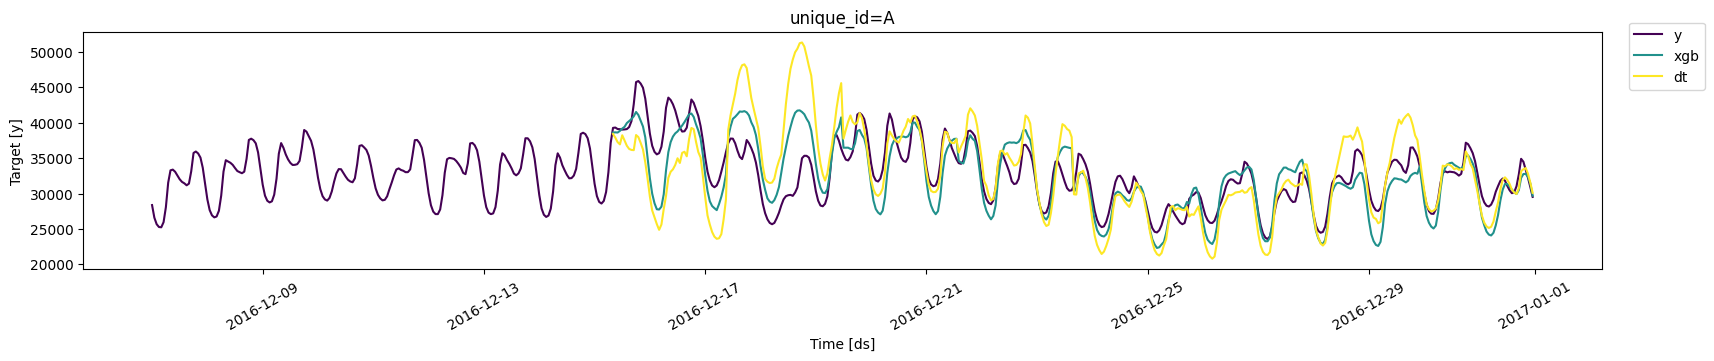

In [55]:
# 3.2 plotting

from utilsforecast.plotting import plot_series


plot_series(df=train, 
                forecasts_df= cv_df.drop(columns=['cutoff', 'y']),
                max_insample_length=600,
                palette='viridis', 
                models=['xgb','dt']
        )